# Semantic Analysis

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [24]:
root_dir = "/cluster/home/kamara/syntax-shap"
data_save_dir = "/cluster/home/kamara/syntax-shap/data"

dataset = "negation"
model_name = "mistral"
threshold_ = 0.5
seed_ = 0


In [25]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/explanations/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-4]
            model_name = parts[-3]
            algorithm = parts[-2]
            seed = parts[-1].split('.pkl')[0]  # Removes the file extension
           
            if eval(seed) == seed_:
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['input'].str.split().apply(len)
                df['explanation'] = df['explanation'].apply(lambda x: x.reshape(-1))

                # Append to the list of dataframes
                df_list.append(df)

# Concatenate all dataframes in the list
df_explanation = pd.concat(df_list, ignore_index=True)
df_explanation


,input_id,input,explanation,algorithm,n_token
0,291,A dog sees with,"[-29173.0, 28501.0, 3571.0, -3251.0]",partition,4
1,421,Maria is a bride with a,"[32656.0, -10314.0, -2781.0, 18059.0, 18148.0,...",partition,6
2,448,A wolf sees without,"[-21649.0, 20525.0, -25224.0, 6448.0]",partition,4
3,63,Rome is located in,"[-29036.0, -28348.0, -23678.0, -34334.0]",partition,4
4,362,Anna is a uncle without a,"[12906.0, -20102.0, 5429.0, -13425.0, 22666.0,...",partition,6
...,...,...,...,...,...
1655,530,A person has no,"[0.30736842105263157, -0.0074432526814667, 0.0...",syntax,4
1656,491,A guitar has,"[0.16536725482150186, 0.606893721789085, 0.227...",syntax,3
1657,333,Mark is a brother with a,"[0.4922955121908309, -0.04679871567434428, -0....",syntax,6
1658,151,Pittsburgh is located in,"[0.8454179254783484, 0.007804632426988921, 0.0...",syntax,4


## Without and the uninteresting predictions "a" and "the"...

In [18]:
df_explanation['without'] = df_explanation['input'].apply(lambda x: x.endswith('without'))
df_without = df_explanation[df_explanation['without']==True]

In [19]:
df_without

,input_id,input,explanation,algorithm,n_token,without
1,430,A horse sees without,"[-8078.0, 8290.0, -11192.0, 16700.0]",partition,4,True
10,474,A bicycle moves without,"[158.0, 36.0, 395.0, -333.0]",partition,4,True
11,294,A bear sees without,"[-1161.0, 371.0, -29494.0, 29412.0]",partition,4,True
14,300,A monkey sees without,"[-12374.0, -12870.0, 10539.0, 22837.0]",partition,4,True
17,468,A duck sees without,"[6248.0, -5926.0, -17081.0, 18431.0]",partition,4,True
...,...,...,...,...,...,...
2180,478,A car moves without,"[0.43816436226696004, 0.06022091584835845, 0.3...",syntax,4,True
2181,200,A lion walks without,"[0.7354792730728115, 0.1881458605535099, -0.03...",syntax,4,True
2182,182,A fly flies without,"[0.09635374964317295, 0.23675910518217327, 0.6...",syntax,4,True
2184,456,A fish sees without,"[0.16181778006923472, 0.30345437136333503, 0.0...",syntax,4,True


In [20]:
df_str = pd.read_csv(f"/cluster/home/kamara/syntax-shap/data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_predictions.csv")
labels = ["a", "the"]

df_str

,input_id,input,y
0,0,A boy is not a,fool
1,1,A boy is a,young
2,2,A girl is not a,girl
3,3,A girl is a,girl
4,4,A brother is not a,murderer
...,...,...,...
529,529,A person has,no
530,530,A person has no,right
531,531,A person has,no
532,532,A person does not have,to


In [29]:
df_w = pd.merge(df_without, df_str, on=['input', 'input_id'])

def is_a(x):
    return x=='a' or x=='the'

df_w['is_a'] = df_w['y'].apply(lambda x: is_a(x))
df_a = df_w[df_w['is_a']==True]

In [34]:
df_w['tokens'] = df_w['input'].apply(lambda x: x.split())
df_w['without_pos'] = df_w['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j=='without'])

In [35]:
df_w['without_rank']= df_w.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['without_pos'])[0].item()+1, axis=1)

In [36]:
df_w.groupby(['algorithm']).mean().reset_index()


,algorithm,input_id,n_token,without,is_a,without_rank
0,lime,323.886792,4.0,1.0,0.0,2.358491
1,partition,323.886792,4.0,1.0,0.0,1.867925
2,shap,323.886792,4.0,1.0,0.0,2.264151
3,syntax,323.886792,4.0,1.0,0.0,2.301887
4,syntax-w,323.886792,4.0,1.0,0.0,2.301887


## Importance of Negations when the model does not capture them

In [26]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/scores/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            if (eval(threshold) == threshold_) and (eval(seed) == seed_):
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['input'].str.split().apply(len)

                # Append to the list of dataframes
                df_list.append(df)

df_final_single_threshold = pd.concat(df_list, ignore_index=True)
df_final_single_threshold


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,algorithm,n_token
0,0.420129,0.378165,0.375612,-1.961204,0.2,0.781496,94,Dallas is not located in,partition,5
1,0.010138,0.010138,0.010138,-9.224166,0.2,0.785604,98,Detroit is not located in,partition,5
2,0.184373,0.177081,0.184373,-3.230112,0.4,0.709440,97,Denver is located in,partition,4
3,-0.054903,0.020616,0.014170,-0.852201,0.1,0.575964,355,Martha is a aunt with a,partition,6
4,0.030357,-0.155401,-0.130865,0.687662,0.7,0.296770,305,A lion sees with,partition,4
...,...,...,...,...,...,...,...,...,...,...
1655,0.031757,0.031757,0.031757,-10.365891,0.0,0.707965,525,A family has,syntax,3
1656,0.052742,0.052742,0.026503,-10.873182,0.0,0.792306,358,Kate is a aunt without a,syntax,6
1657,-0.089850,-0.028677,-0.086198,0.227605,0.8,0.091859,255,A fish has,syntax,3
1658,0.567671,0.561054,0.189702,-4.017129,0.0,0.898721,85,Boston is located in,syntax,4


In [27]:
df_str = pd.read_csv(f"/cluster/home/kamara/syntax-shap/data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_labeled_predictions.csv")
df_str

,input_id,input,y,label
0,0,A boy is not a,son,NaN
1,1,A boy is a,son,NaN
2,2,A girl is not a,woman,0.0
3,3,A girl is a,girl,1.0
4,4,A brother is not a,son,NaN
...,...,...,...,...
529,529,A person has,died,NaN
530,530,A person has no,right,NaN
531,531,A person has,died,NaN
532,532,A person does not have,to,NaN


In [28]:
df_label = df_str[(df_str['label'].notna()) & (df_str['label'] == 0)]
df_label

negations = ["not", "without", "no"]

df_label['tokens'] = df_label['input'].apply(lambda x: x.split())
df_label['neg_pos'] = df_label['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in negations])

/tmp/ipykernel_17054/3823840268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['tokens'] = df_label['input'].apply(lambda x: x.split())
/tmp/ipykernel_17054/3823840268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['neg_pos'] = df_label['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in negations])


In [29]:
sample = pd.merge(df_explanation, df_final_single_threshold, on=['input', 'input_id', 'algorithm', 'n_token'])
sample_with_y = pd.merge(sample, df_label, on=['input', 'input_id'])

In [30]:
def normalize(x):
    x = np.array(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))

sample_with_y['explanation'] = sample_with_y['explanation'].apply(lambda x: normalize(x))

In [176]:
"""df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']
has_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))
# Print the rows with NaN values in 'explanation'
rows_with_nan_explanation = df_lime[~has_nan_explanation]
filtered_ids = rows_with_nan_explanation['input_id']

sample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"""

In [31]:
sample_with_y['neg_val']= sample_with_y.apply(lambda x: x['explanation'][x['neg_pos'][0]], axis=1)
sample_with_y['neg_rank']= sample_with_y.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['neg_pos'])[0].item()+1, axis=1)

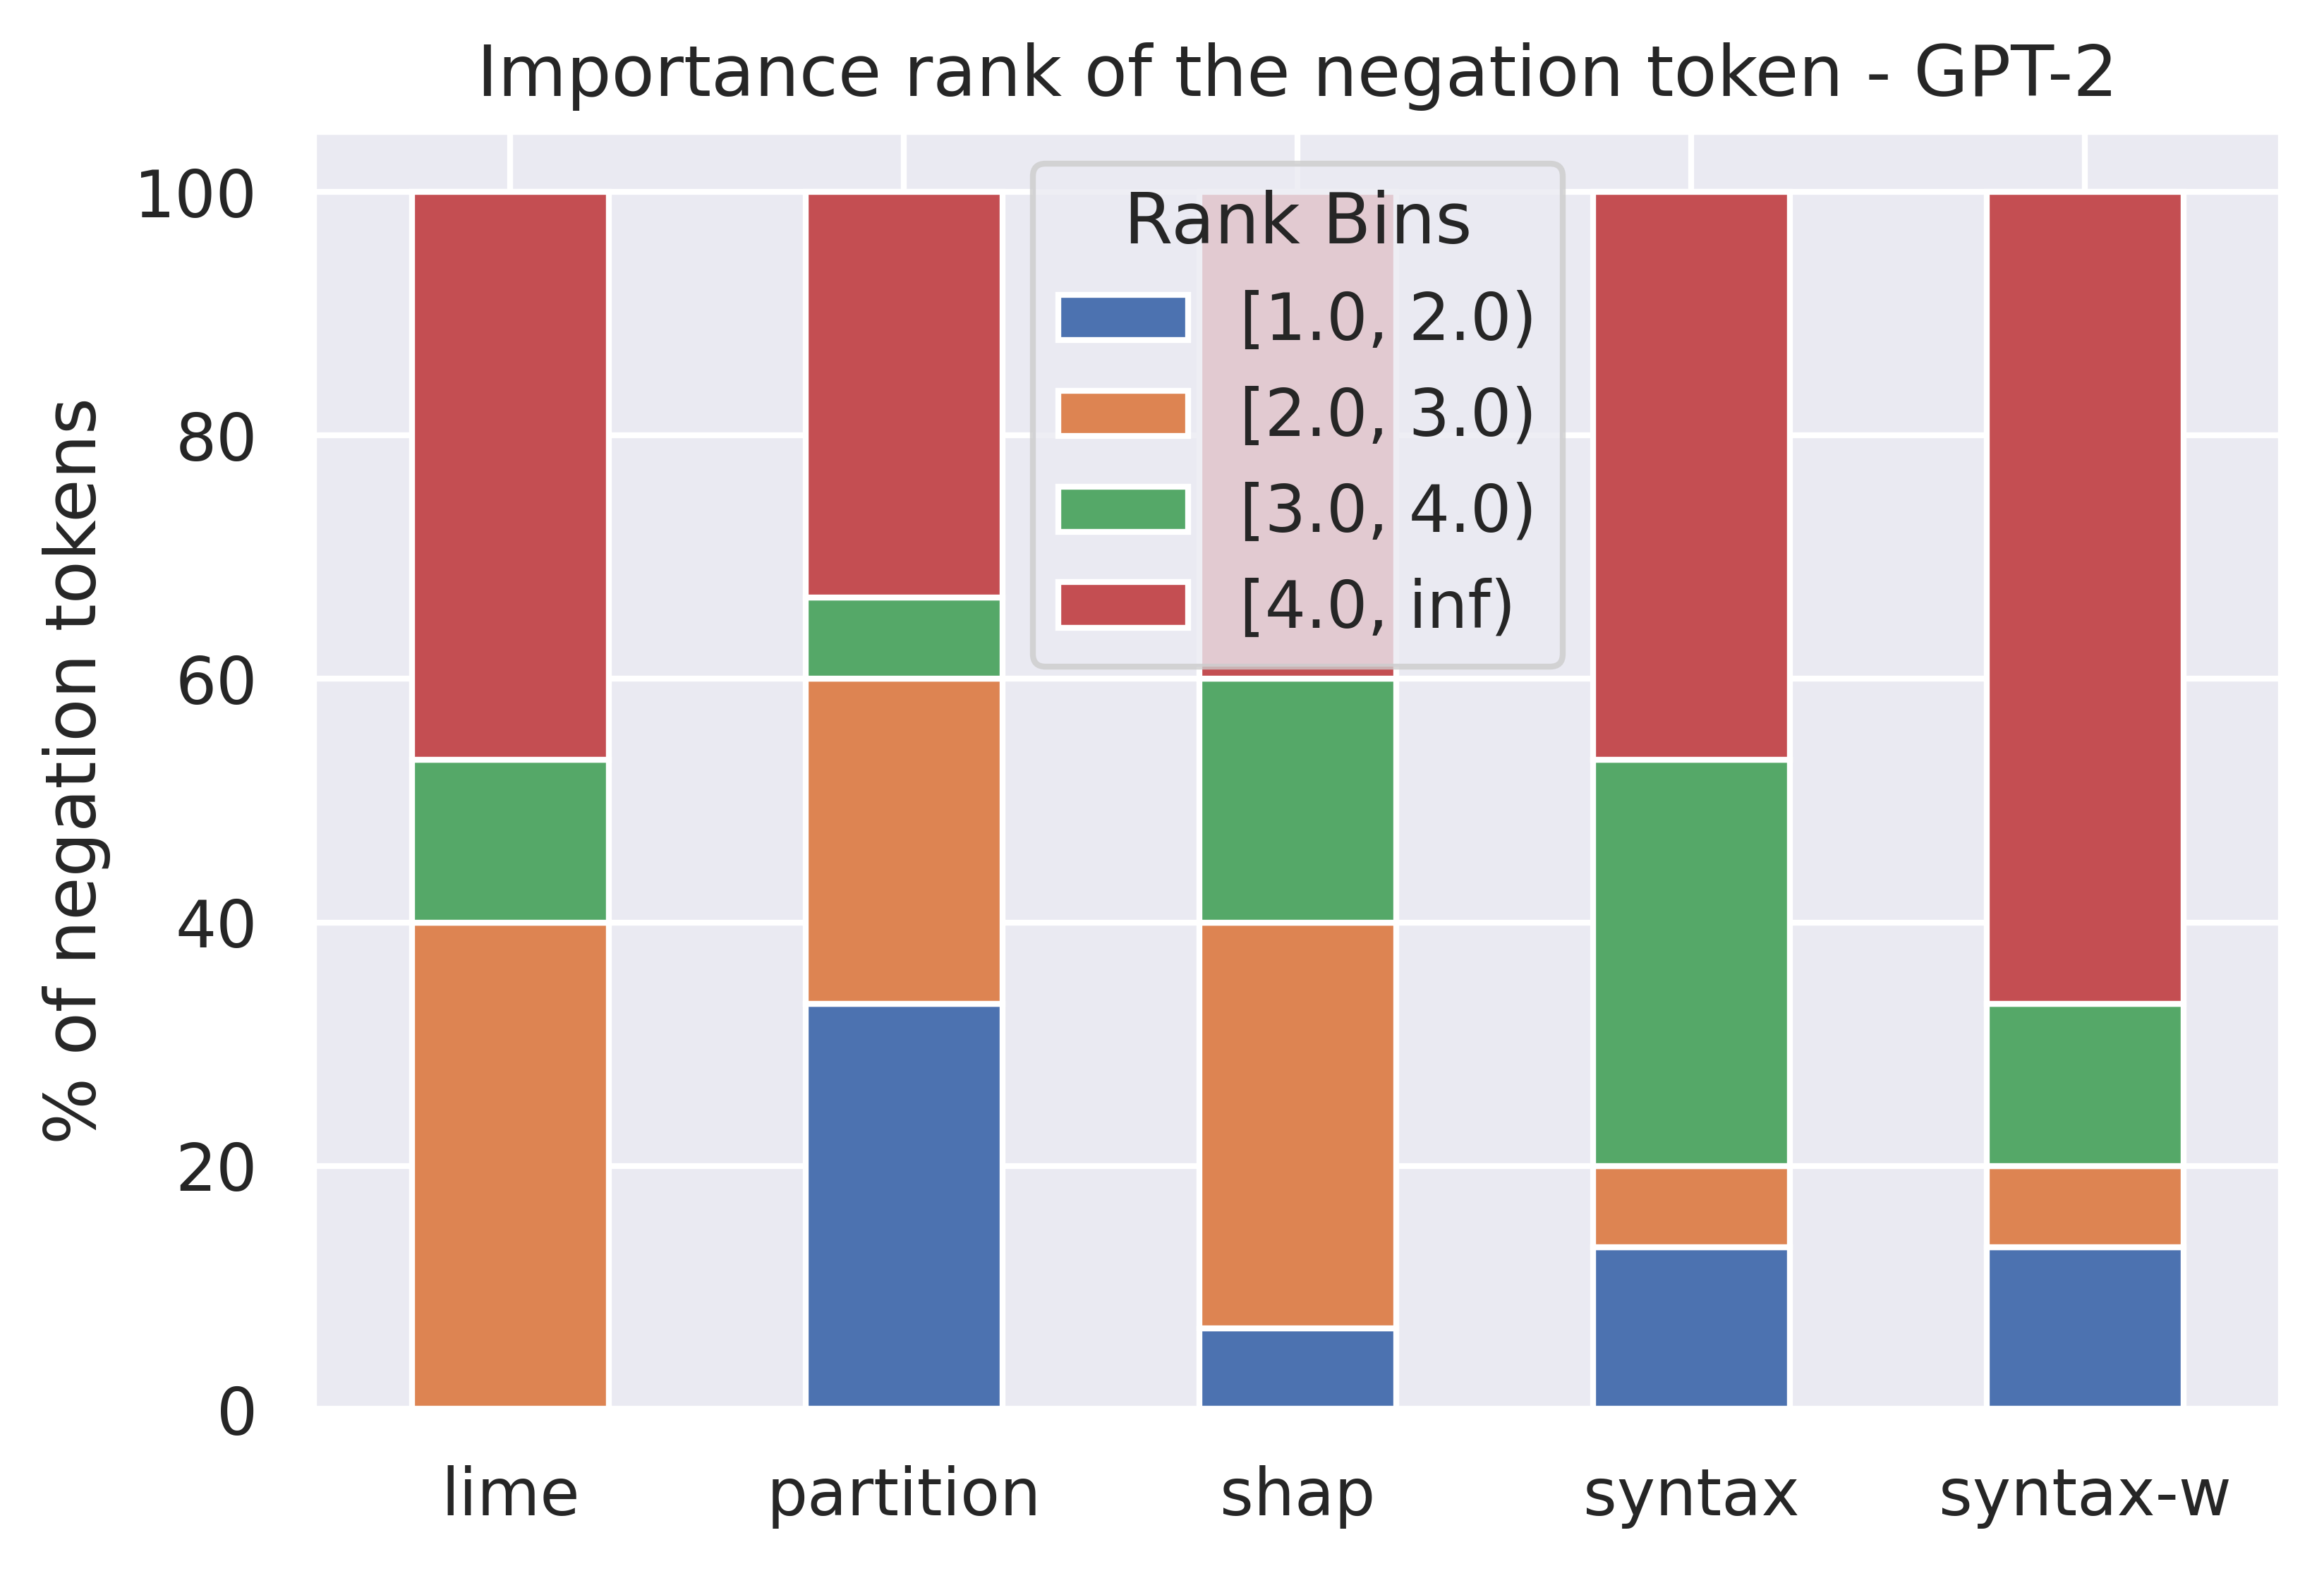

In [32]:
# Group by 'algorithm' and calculate percentage of rows in each bin
result = sample_with_y.groupby('algorithm')['neg_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)

# Plot
result.plot(kind='bar', stacked=True)
plt.title('Importance rank of the negation token - GPT-2')
plt.xlabel('')
plt.ylabel('% of negation tokens')
plt.xticks(rotation=0)
plt.legend(title='Rank Bins')

plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_ranks.png", bbox_inches='tight', dpi=600)
#plt.show()


In [16]:
sample_with_y['neg_rank_high'] = sample_with_y['neg_rank'].apply(lambda x: 1 if x>=4 else 0)


In [17]:
sample_with_y.groupby(['algorithm']).mean().reset_index()

,algorithm,input_id,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,label,neg_val,neg_rank,neg_rank_high
0,lime,285.142857,5.142857,0.097140,0.097140,0.085650,-10.600668,0.035714,0.555829,0.0,0.834892,2.142857,0.142857
1,partition,285.142857,5.142857,0.070362,0.083303,0.092514,-6.929546,0.250000,0.422241,0.0,0.548672,3.000000,0.357143
2,shap,285.142857,5.142857,0.094444,0.080564,0.094957,-6.916637,0.121429,0.508377,0.0,0.384876,3.285714,0.285714
3,syntax,285.142857,5.142857,0.087937,0.081290,0.090669,-5.616655,0.214286,0.393510,0.0,0.567398,2.285714,0.214286
4,syntax-w,285.142857,5.142857,0.082378,0.090344,0.089458,-7.184130,0.150000,0.453434,0.0,0.473569,2.428571,0.285714


In [226]:
df_neg = sample_with_y.groupby(['algorithm']).mean().reset_index()
df_neg

,algorithm,input_id,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,label,neg_val,neg_rank
0,lime,285.142857,5.142857,0.097140,0.097140,0.085650,-10.600668,0.035714,0.555829,0.0,0.834892,2.142857
1,partition,285.142857,5.142857,0.070362,0.083303,0.092514,-6.929546,0.250000,0.422241,0.0,0.548672,3.000000
2,shap,285.142857,5.142857,0.094444,0.080564,0.094957,-6.916637,0.121429,0.508377,0.0,0.384876,3.285714
3,syntax,285.142857,5.142857,0.087937,0.081290,0.090669,-5.616655,0.214286,0.393510,0.0,0.567398,2.285714
4,syntax-w,285.142857,5.142857,0.082378,0.090344,0.089458,-7.184130,0.150000,0.453434,0.0,0.473569,2.428571


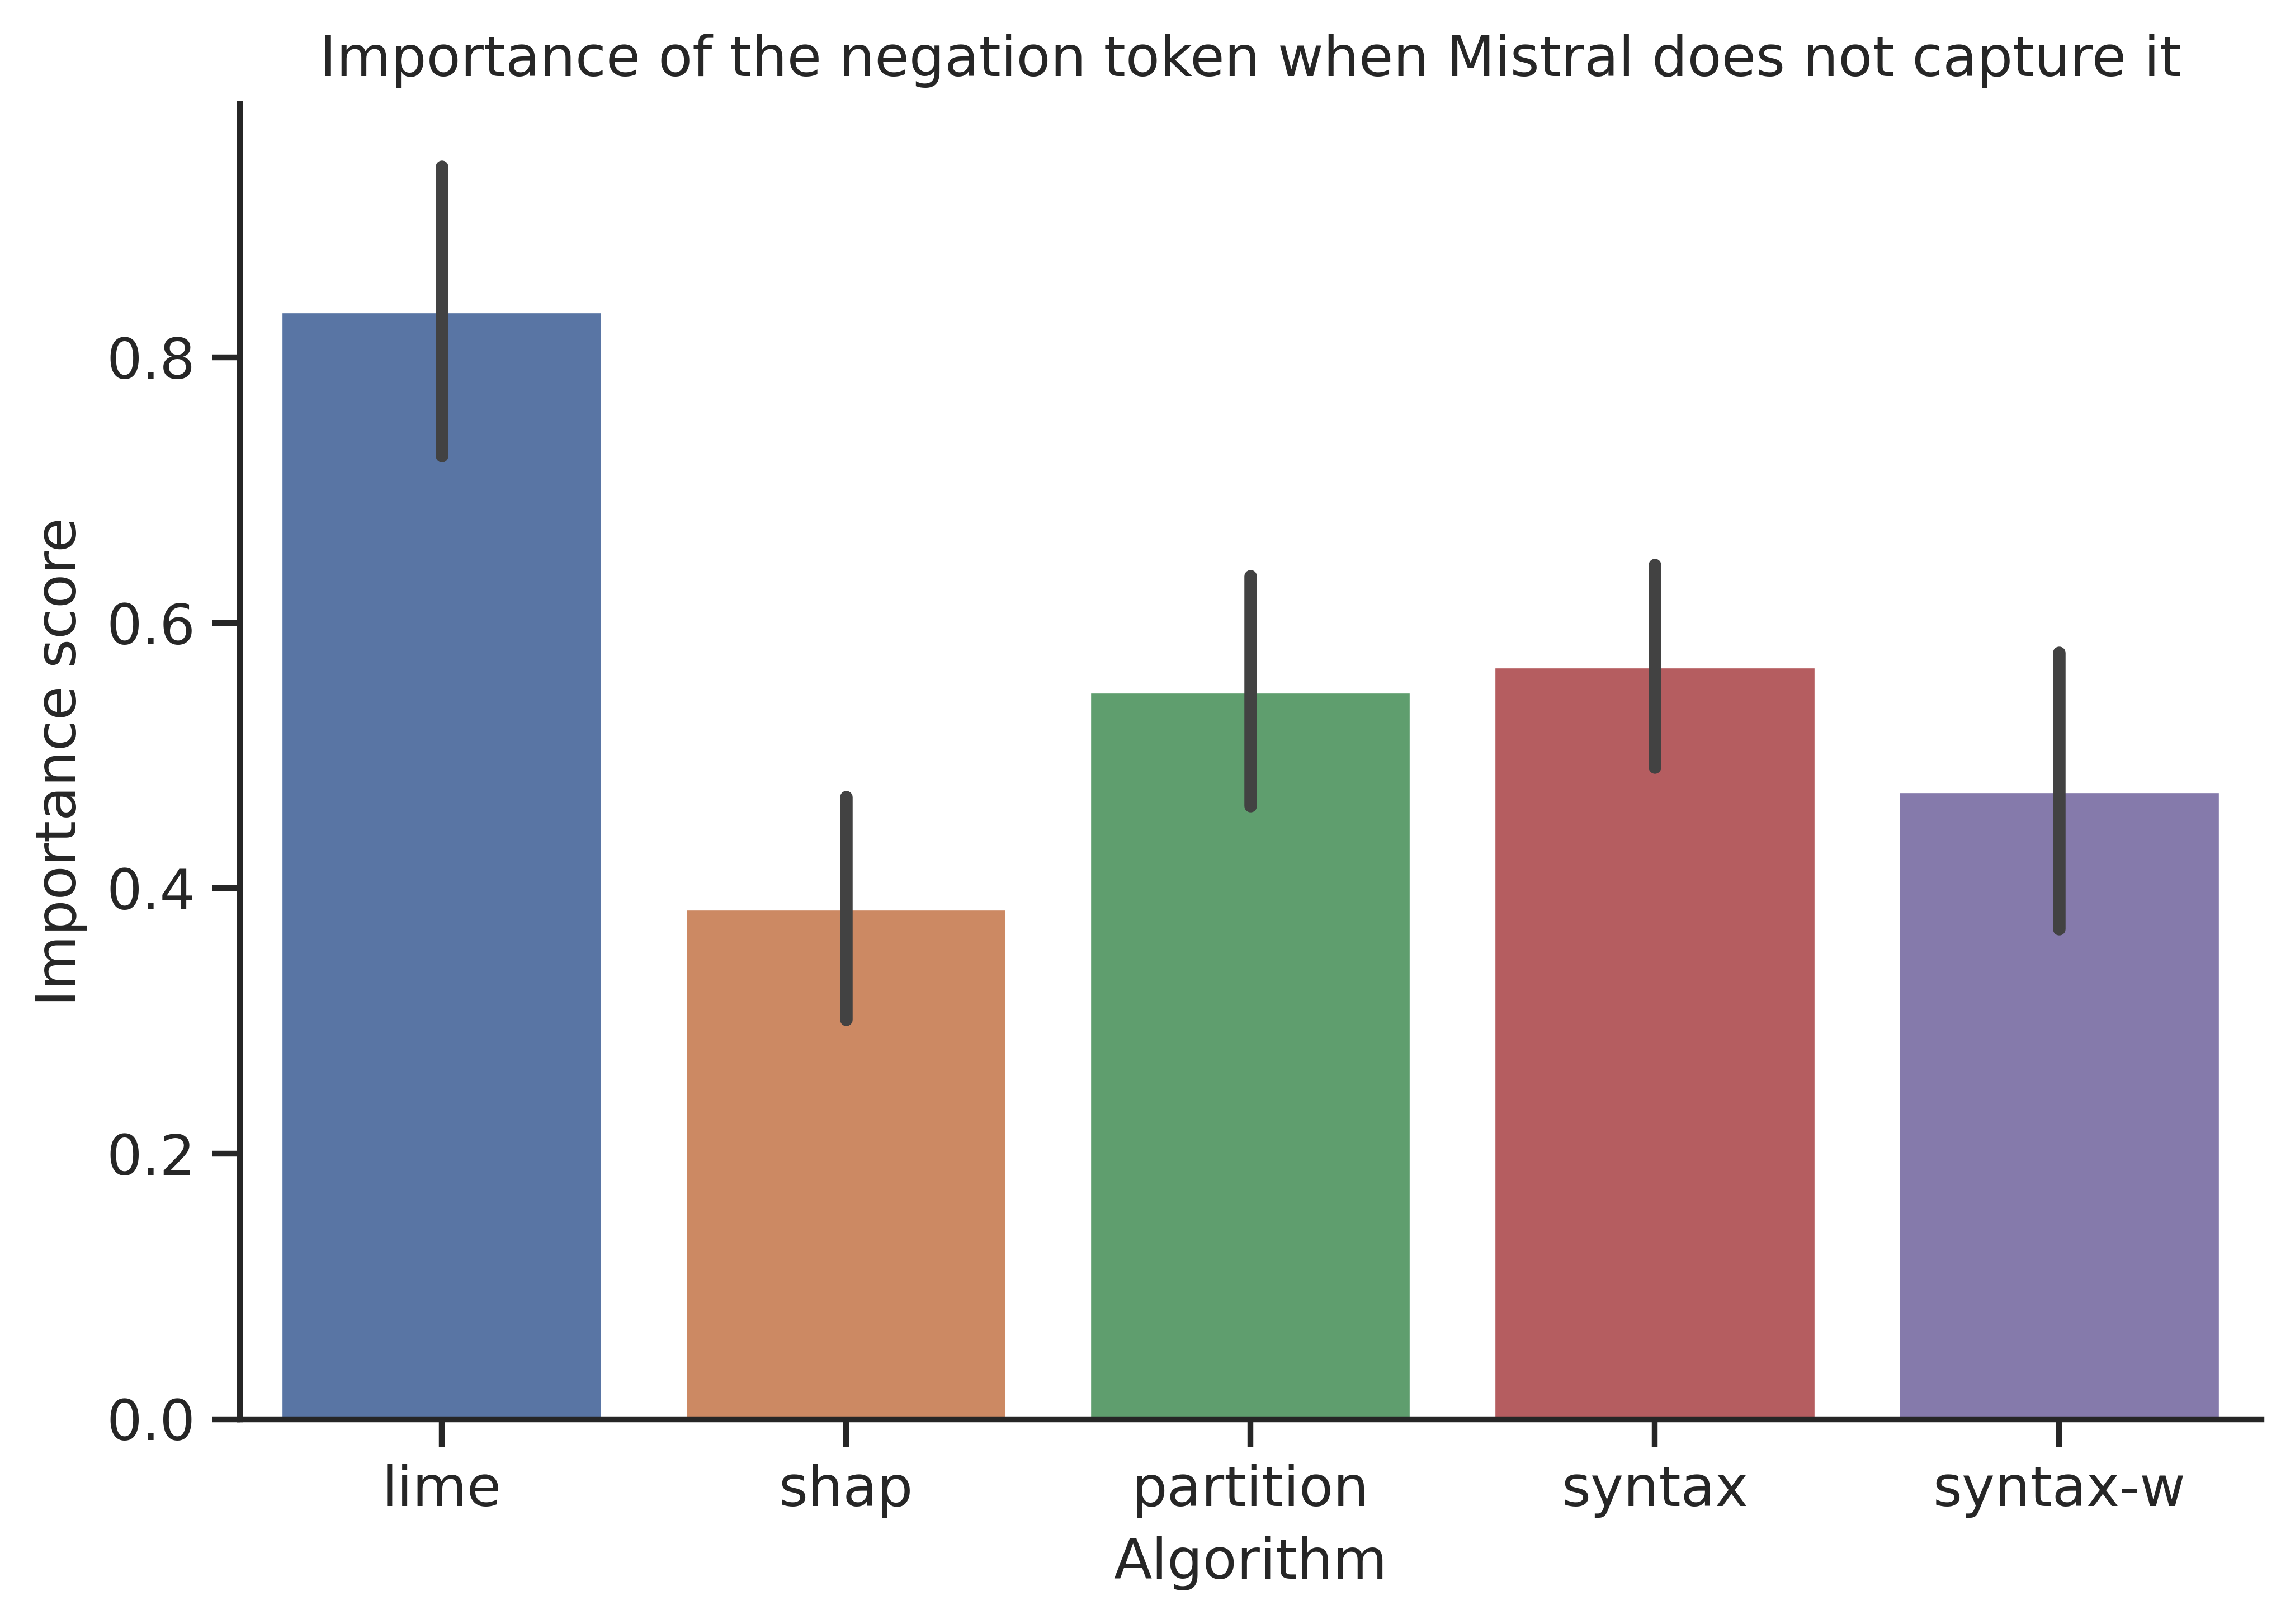

In [227]:
# Plot
df = sample_with_y

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))
sns.barplot(data=df, x='algorithm', y='neg_val', errorbar='se')
plt.title('Importance of the negation token when Mistral does not capture it')
plt.xlabel('Algorithm')
plt.ylabel('Importance score')
sns.despine()
plt.tight_layout()

plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_importance.png", bbox_inches='tight', dpi=600)

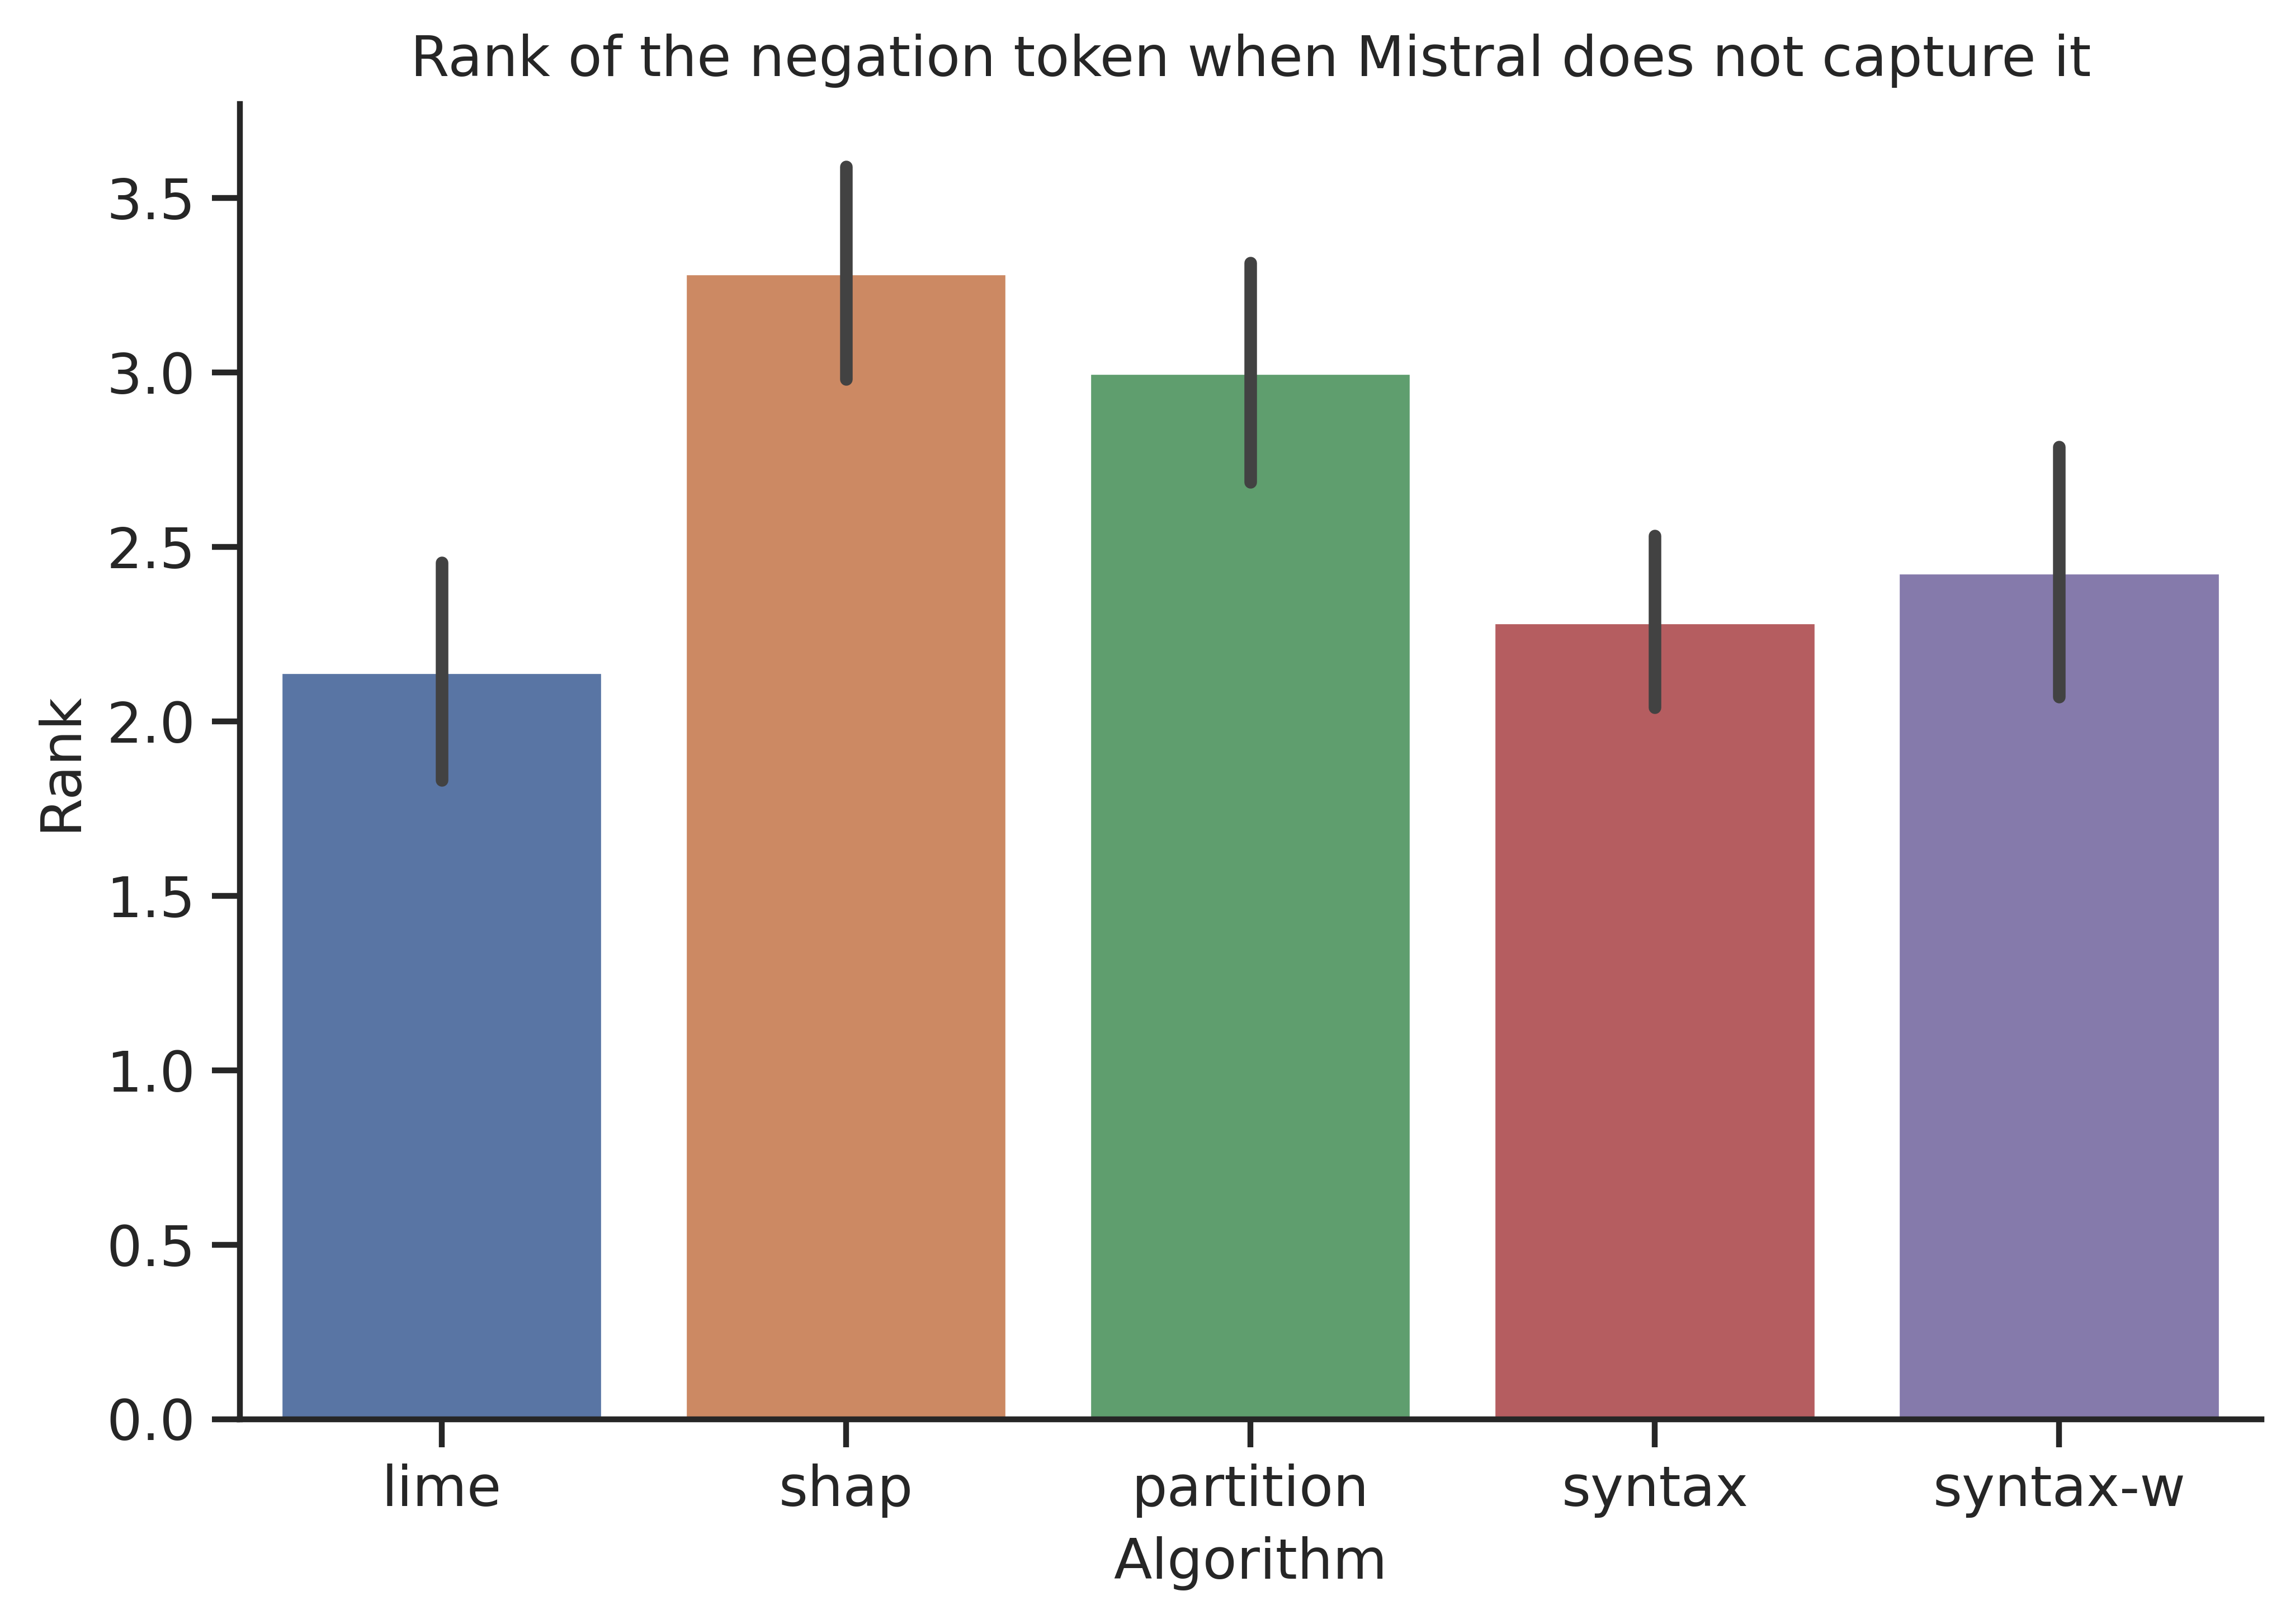

In [228]:
# Plot
df = sample_with_y

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))
sns.barplot(data=df, x='algorithm', y='neg_rank', errorbar='se')
plt.title('Rank of the negation token when Mistral does not capture it')
plt.xlabel('Algorithm')
plt.ylabel('Rank')
sns.despine()
plt.tight_layout()

plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_rank.png", bbox_inches='tight', dpi=600)

In [61]:
#for i in selected_indices:
i = selected_indices[0]
instance = sample_with_y[sample_with_y['input_id']==i]
info = instance.groupby(['input_id', 'input', 'y', 'label', 'n_token']).mean().reset_index()
print("input_id: ", info['input_id'])
print("input: ", info['input'])  
instance['tokens'] = instance['input'].apply(lambda x: x.split())
df = instance[['tokens', 'explanation', 'algorithm']]
df = df.apply(pd.Series.explode)
df['rank'] = df.groupby('algorithm')['explanation'].transform(lambda x: x.rank())



    #df#.pivot(index='tokens', columns='algorithm', values='explanation').plot(kind='bar', stacked=True)
    

input_id:  0    2
Name: input_id, dtype: int64
input:  0    A girl is not a
Name: input, dtype: object


/tmp/ipykernel_26212/2115529381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance['tokens'] = instance['input'].apply(lambda x: x.split())


<AxesSubplot:xlabel='tokens', ylabel='rank'>

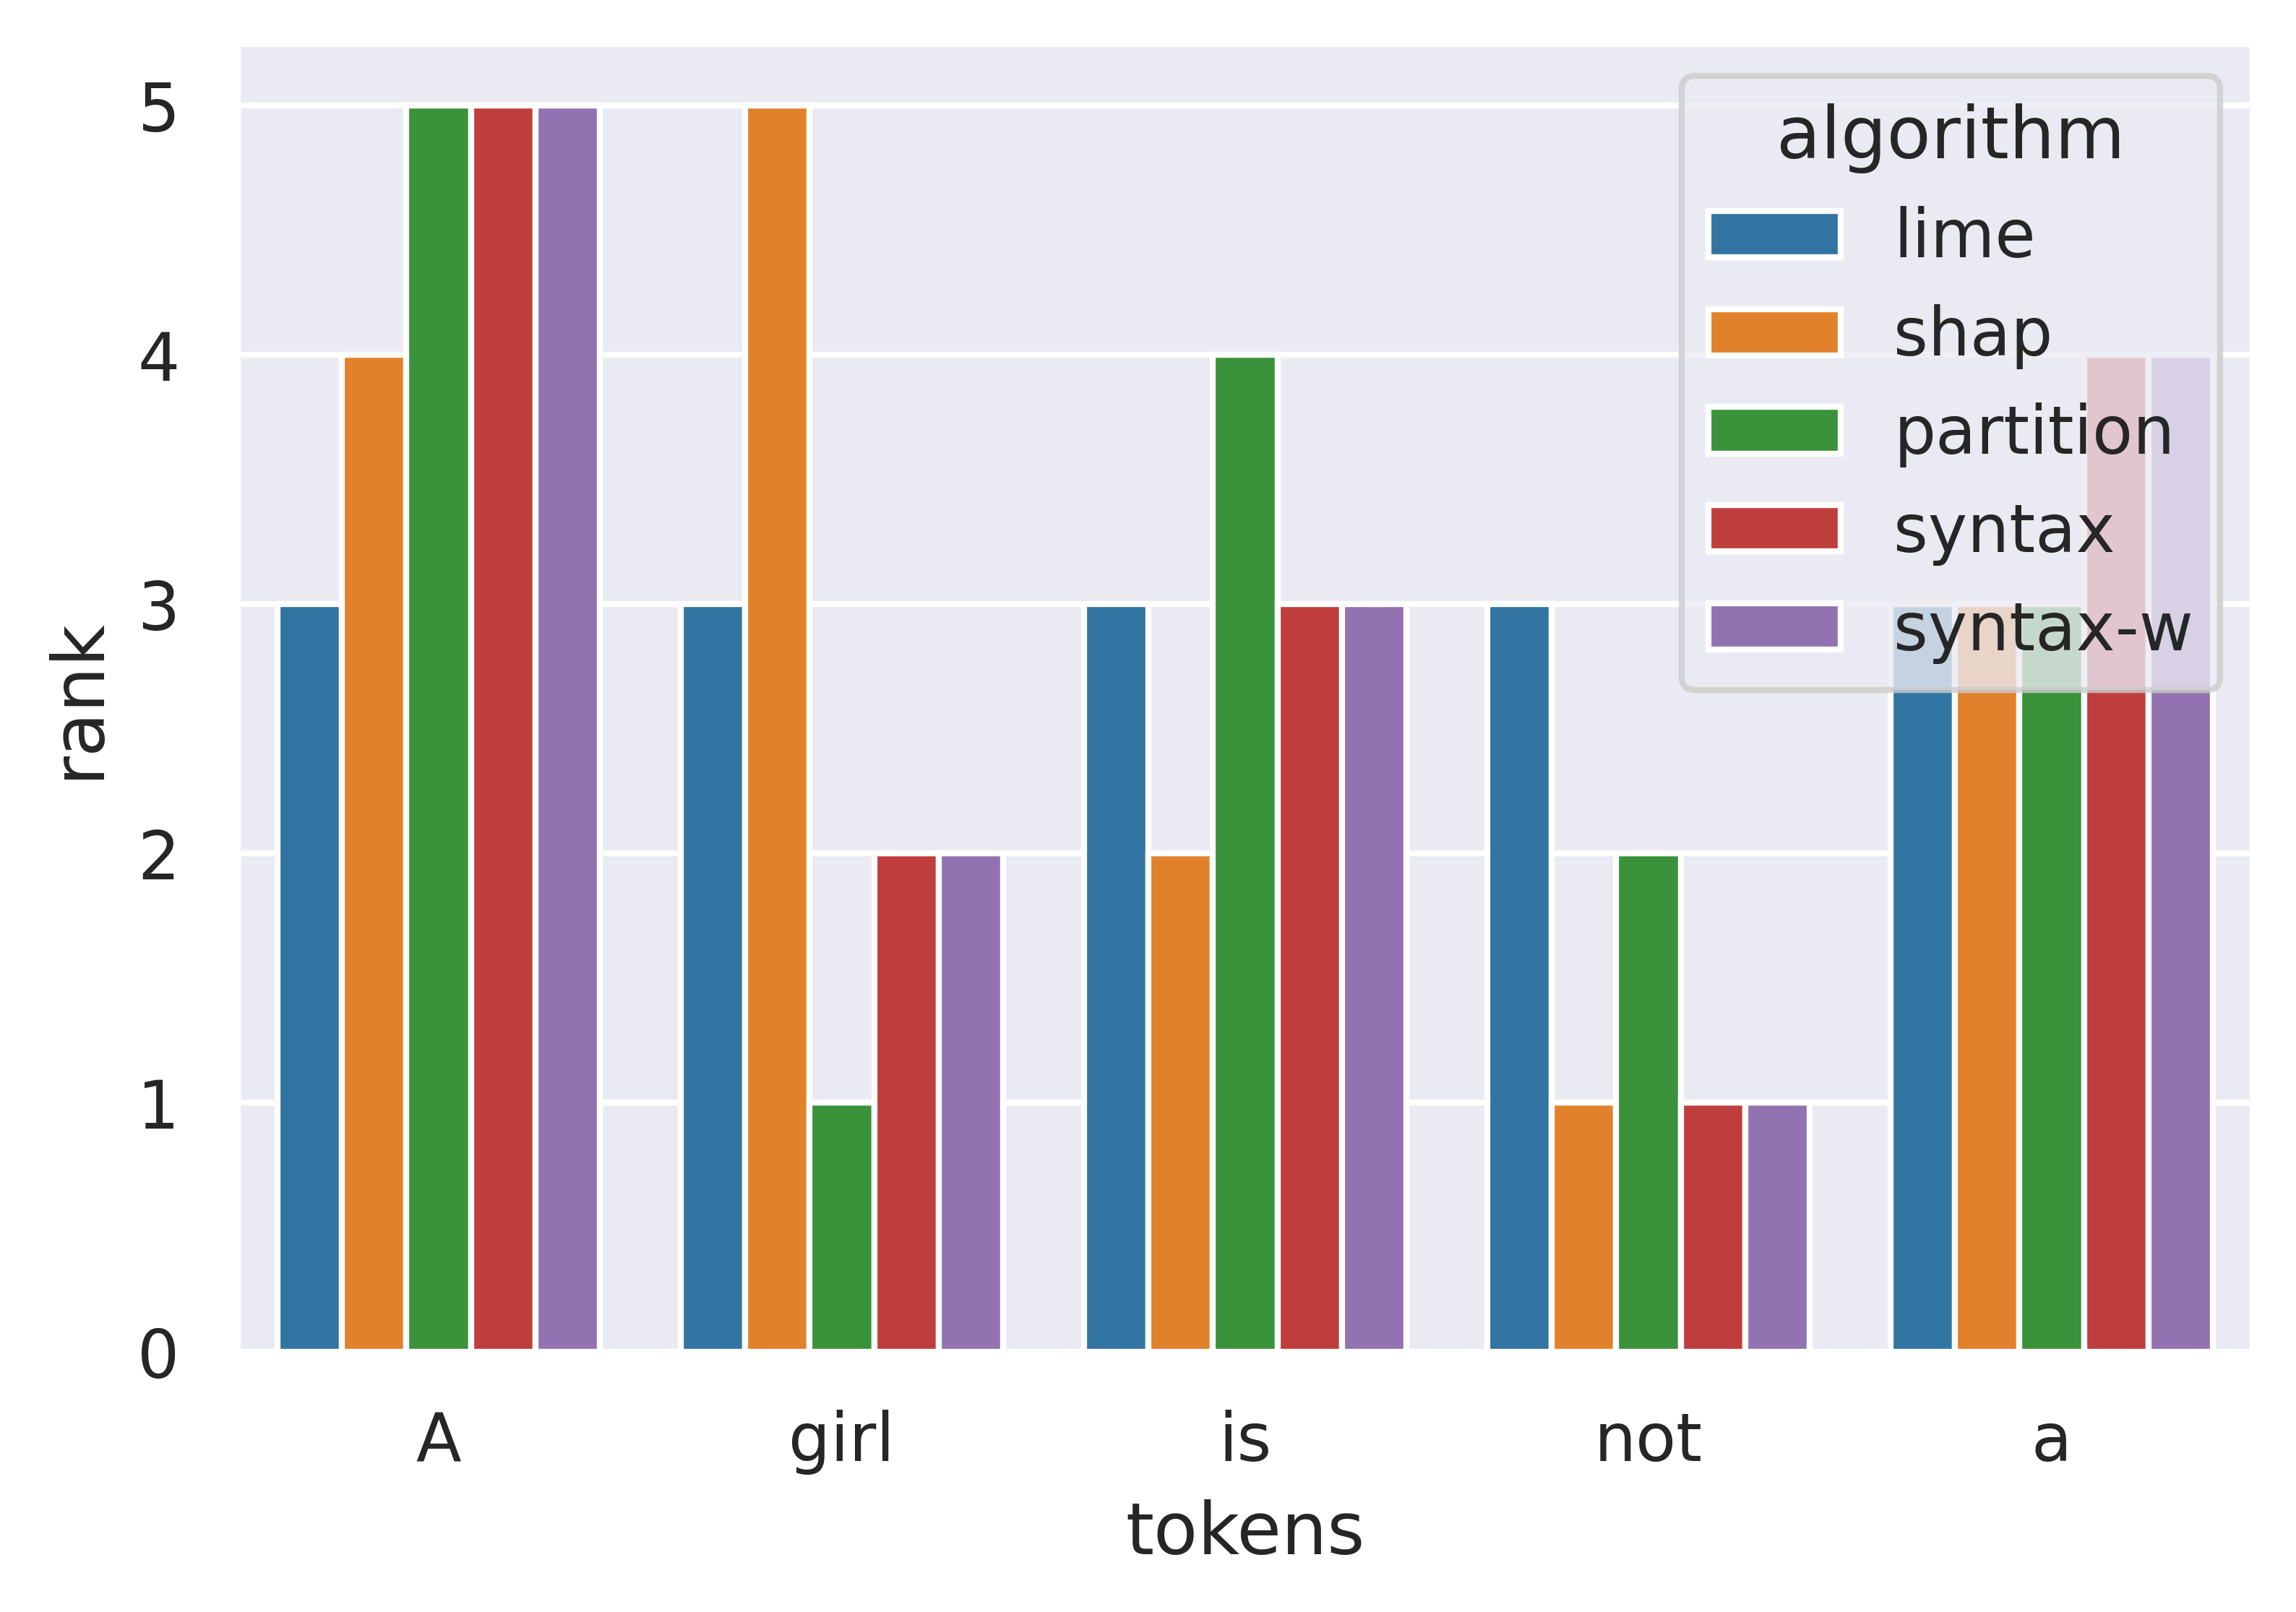

In [62]:

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

sns.barplot(x='tokens', y='rank', hue='algorithm', data=df, palette=palette)


In [68]:
df

,tokens,explanation,algorithm,rank,inv_rank
15,A,1011.0,partition,5.0,1.0
15,girl,-15591.0,partition,1.0,5.0
15,is,-7770.0,partition,4.0,2.0
15,not,-10870.0,partition,2.0,4.0
15,a,-9509.0,partition,3.0,3.0
16,A,0.627284,syntax-w,5.0,1.0
16,girl,-0.010315,syntax-w,2.0,4.0
16,is,0.071414,syntax-w,3.0,3.0
16,not,-0.030519,syntax-w,1.0,5.0
16,a,0.342136,syntax-w,4.0,2.0


/tmp/ipykernel_26212/3307771496.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)


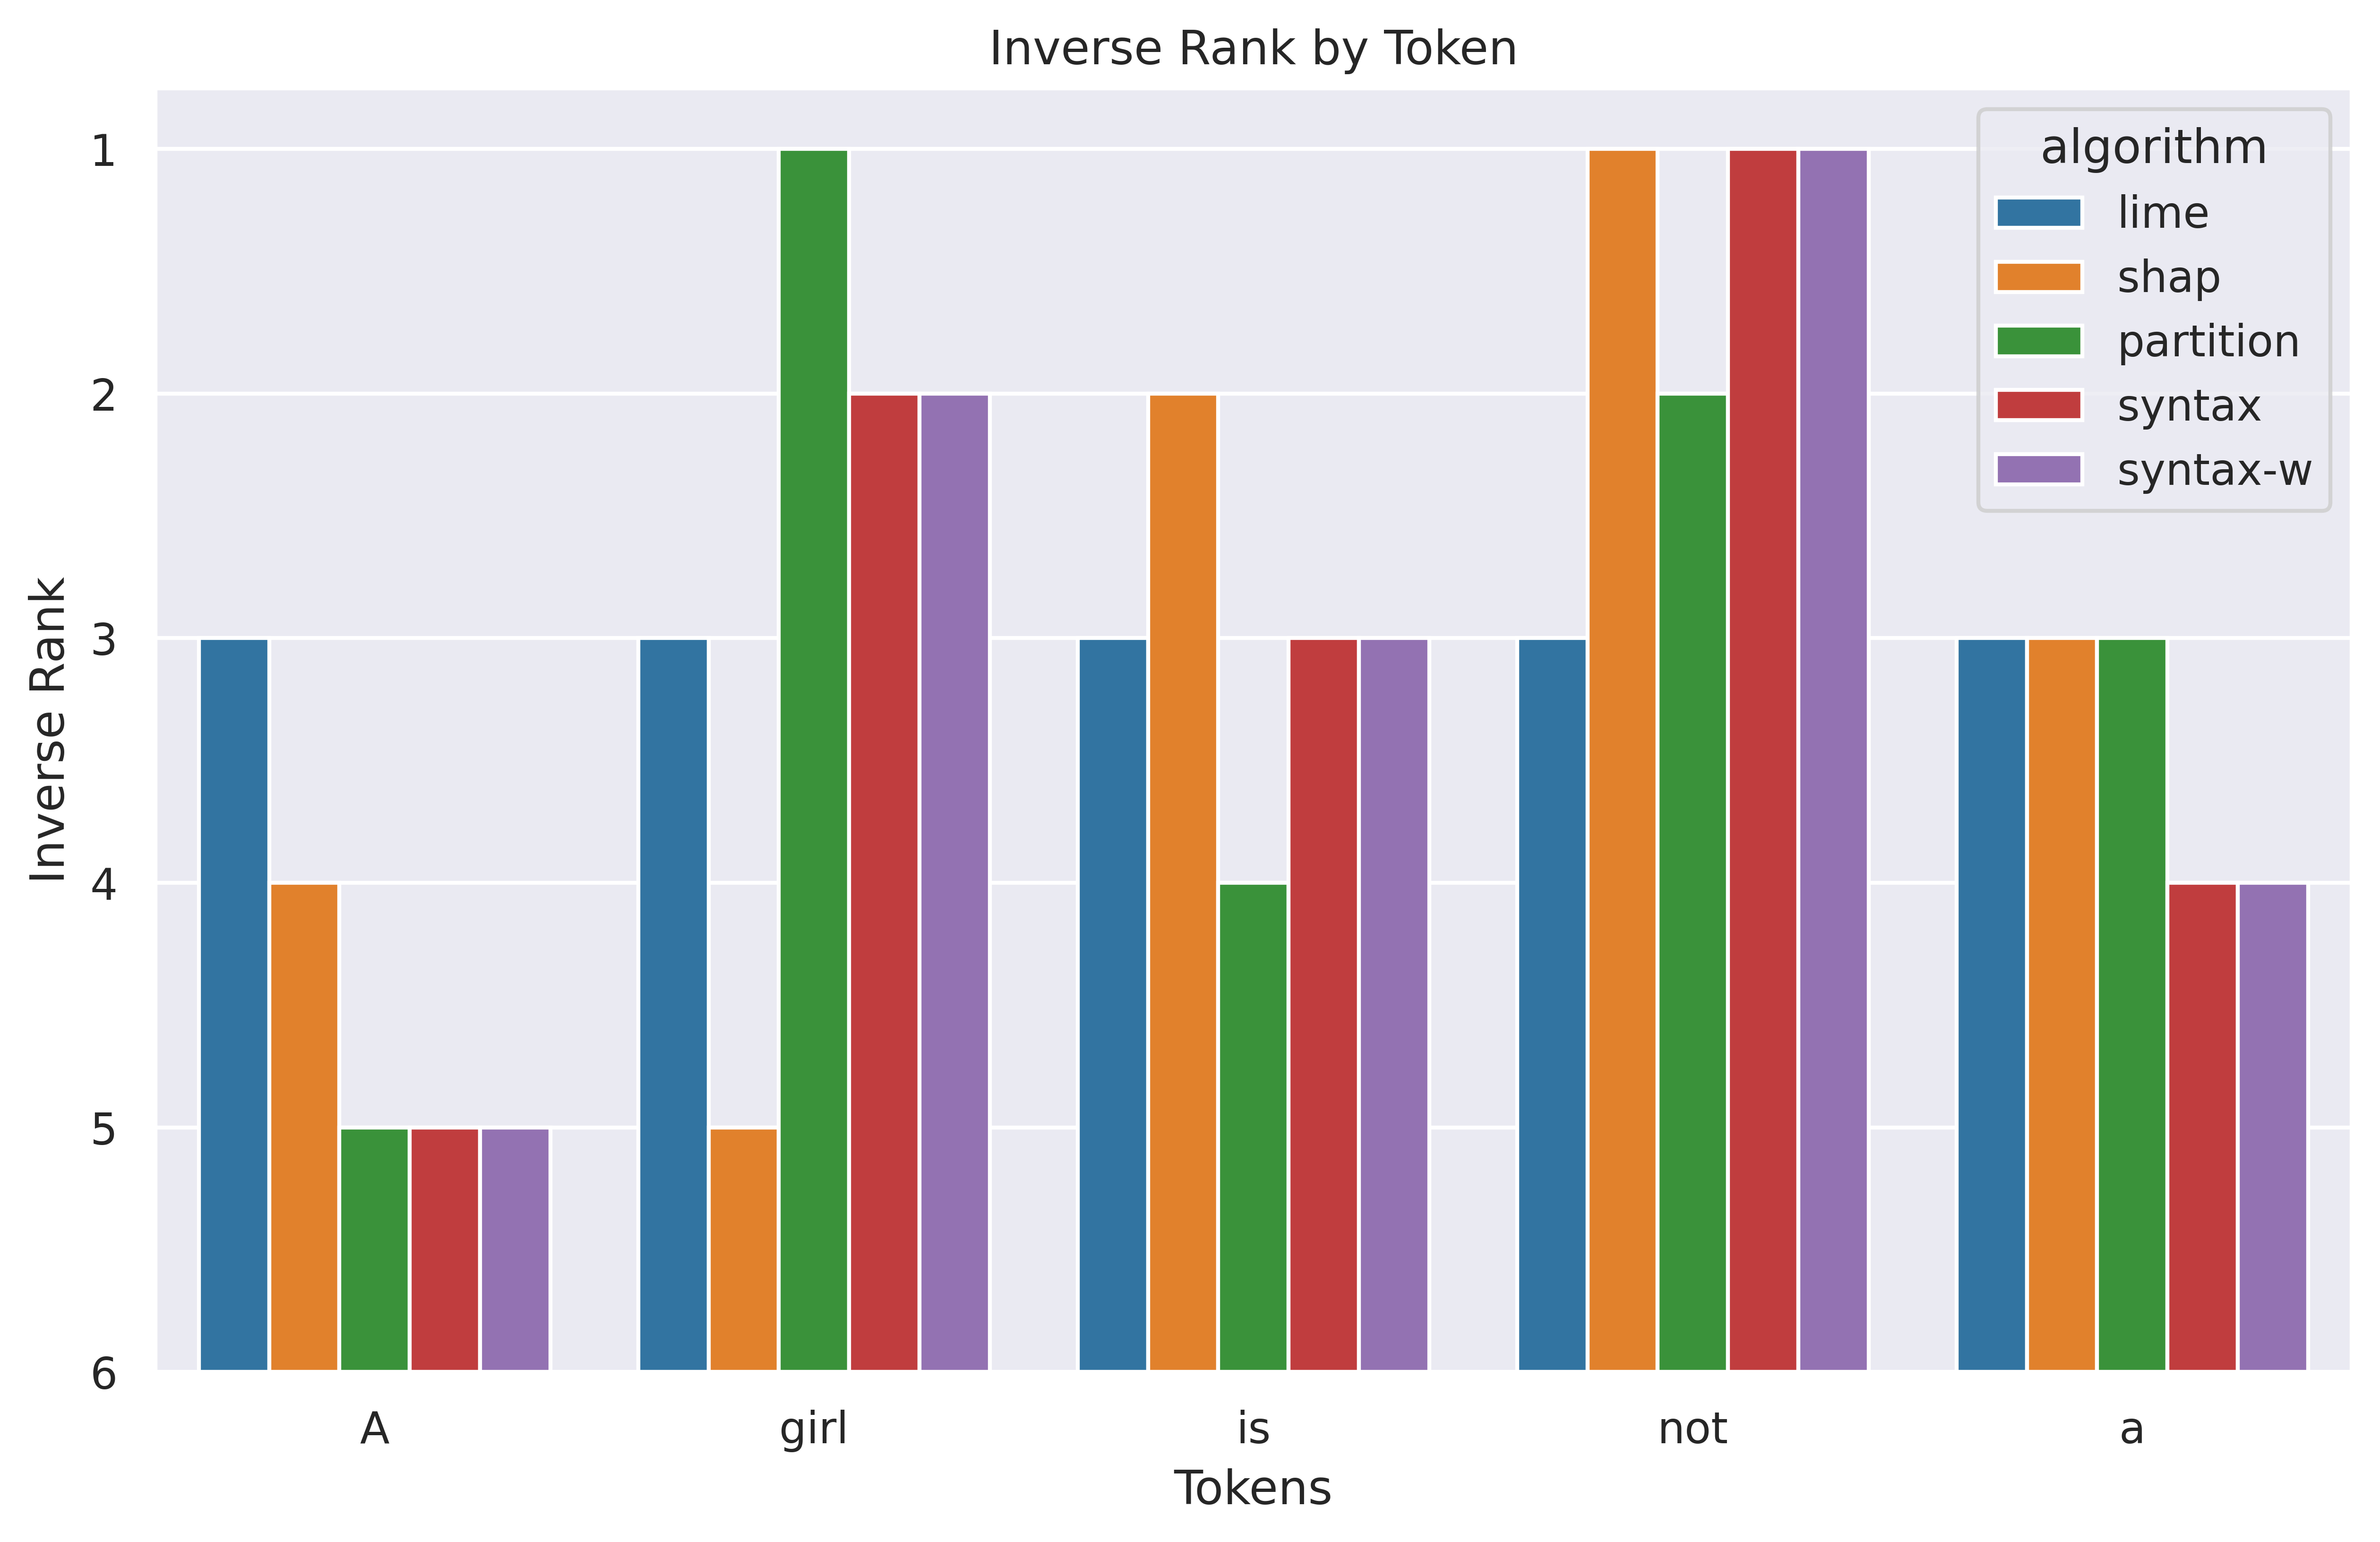

In [78]:
# Inverse the rank
max_rank = 5
df['inv_rank'] = max_rank - df['rank'] + 1  # Adding 1 to start the rank from 1 instead of 0

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='tokens', y='inv_rank', hue='algorithm', data=df, palette=palette)


# Relabel the y-axis
num_ticks = df['inv_rank'].nunique()
new_labels = [str(i) for i in range(num_ticks+1, 0, -1)]  # Reverse order
ax.set_yticklabels(new_labels)

plt.title('Inverse Rank by Token')
plt.xlabel('Tokens')
plt.ylabel('Inverse Rank')
plt.show()